# Validere Take-Home Assignment

## October 20, 2021

## Author: Arash Shamseddini

### Thank you Validere team for giving me the opportunity 🙏

### Let's get down to business 🚀

For this assignment, I have chosen to answer the first question as shown below:

![Question](images/Q.png)

### 1- Introduction

This question is challenging in a sense that there are a lot of controversy going on around the subject of "Housing Prices" in Canada  and most especially in **Toronto**.

As pointed out in an article by [Thais R](https://newcanadianlife.com/why-is-housing-so-expensive-in-toronto/), "*Toronto seems to be turning into major world cities, and in turn, people are willing to pay extremely high prices to live in these hubs, just like in the American cities mentioned earlier*".

As [Mark Rosanes](https://www.mpamag.com/ca/mortgage-industry/industry-trends/whats-driving-up-real-estate-prices-in-toronto/287415) discusses in his post, these high prices in City of Toronto stem from a number of reasons including but not limited to:
- Supply and Demand Imbalance
- Taxes and development charges
- Foreign buyers
- Low interest rates

In this analysis, I have studied the effects of some of these factors on the housing price in the **City of Toronto**.

**Note:** I have limited my study to the **[City of Toronto](https://en.wikipedia.org/wiki/Toronto)** and not **[Greater Toronto Area](https://en.wikipedia.org/wiki/Greater_Toronto_Area)** (aka GTA). Therefore, any future reference to the name "Toronto" is associated with the **City of Toronto**. 

Below map, indicates both areas.

![Question](images/toronto.png)

**Note:** In this report I, as a private citizen, have used open-source data available to the public and made proper references where necessary. Findings of the reports have also been validated by making reference to literature.

In [153]:
# Necessary Imports
import numpy as np
import pandas as pd
import altair as alt
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

### 2-Overview of the Current Situation

In order to better understand the current situation with the housing market in Toronto, I have defined **Unaffordability Ratio** (i.e. price-to-income ratio) as below:


$$\text{Unaffordability Ratio} = \frac{\text{Average Sales Price}}{\text{Family Median Income}} $$

I have made use of Statistics Canada data for **Family Median Income** (available [here](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1110001701)) and Toronto Regional Real Estate Board (available [here](https://trreb.ca/files/market-stats/market-watch/historic.pdf)) for **Average Sales Price** over the past two decades.

In [4]:
# Reading in the median_income data set
median_income_df = pd.read_csv('data/median_income.csv')

# Reading in the avg_sales_price data set
avg_sales_price_df = pd.read_csv('data/avg_sales_price.csv')

# Merging the two data sets to build Unaffordability Ratio
unaffordability_df = pd.merge(median_income_df, avg_sales_price_df, how="inner", on="year")
unaffordability_df['unaffordability_ratio'] = unaffordability_df['avg_sales_price'] / 
                                              unaffordability_df['median_total_income']  # unaffordability_ratio is defined as 
                                                                                         # the avg_sales_price/median_total_income ration 
    
unaffordability_df

,year,median_total_income,avg_sales_price,unaffordability_ratio
0,2001,57900,251508,4.343834
1,2002,58200,275231,4.729055
2,2003,58500,293061,5.009590
3,2004,60100,315231,5.245108
4,2005,61800,335907,5.435388
5,2006,63800,351941,5.516317
6,2007,66560,376236,5.652584
7,2008,68120,379080,5.564885
8,2009,66790,395234,5.917563
9,2010,68110,431262,6.331846


Let's plot **Unaffordability Ratio** over time as below.

In [118]:
# Plotting Unaffordability Ratio over time
line = alt.Chart(unaffordability_df, title='Unaffodability Ratio vs Time (2001-2019)').mark_line(
    point=True
).encode(
     x=alt.X('year:N', title='Year'),
     y=alt.Y('unaffordability_ratio', title='Unaffordability Ratio'),
)

reference = alt.Chart(pd.DataFrame({'unaffordability_ratio': [5.1]})).mark_rule(color='red').encode(y='unaffordability_ratio')

(line + reference).properties(width=600)

alt.LayerChart(...)

As indicated below [Mark Rosanes](https://www.mpamag.com/ca/mortgage-industry/industry-trends/whats-driving-up-real-estate-prices-in-toronto/287415) discusses that an **Unaffordability Ratio** over `5.1` is equivalent to an **unaffordable housing market**.

![Report1](images/report1.png)

The plot reveals that after 2003, the **Unaffordability Ratio** passed the `5.1` threshold and that we are currently at a value above `9.0` (as authenticated by the article).

Now let's look at the affecting parameters as follows:

### 3- Affecting Parameters

#### 3-1 Supply/Demand

Doing a thorough literature review, it seems like "Supply/Demand" balance plays the key role in **Housing Price** in Toronto and other parameters (e.g. "Interest Rate" or "Foreign Ownership") affect this balance and consequently the **Housing Price**.

[Jason Fernando](https://www.investopedia.com/terms/l/law-of-supply-demand.asp) defines the "Law of Supply and Demand" as "*A theory that explains the interaction between the sellers of a resource and the buyers for that resource. The theory defines the relationship between the price of a given good or product and the willingness of people to either buy or sell it*".

As discussed by this [Investopedia article](https://www.investopedia.com/ask/answers/040215/how-does-law-supply-and-demand-affect-housing-market.asp), "When there is a high demand for a good or service, its price rises. If there is a large supply of a good or service but not enough demand for it, the price falls." and Toronto Housing Market is not an exception.

To better investigate Supply/Demand balance I look at each factor and how they affect the Housing Market in Toronto separately.

##### 3-1-1 Supply

The Supply side of the coin in the Housing Market can be thought as to have two branches:
- **Existing/Active Supply:** This refers to the number of existing houses in the city of Toronto.
- **Potential/Passive Supply:** This refers to the number of houses either starting for construction, under construction or completed in the city of Toronto.

I will look into each branch below.

**Existing/Active Supply**

I have made use of Canadian Census data (available [here](https://www12.statcan.gc.ca/census-recensement/index-eng.cfm)) to query the **Number of Houses (Dwellings)** for each census year.

**Note:** These data are collected each census year and available up to `2016` census year.

In [6]:
# Reading in housing_stock data set
housing_stock_df = pd.read_csv('data/housing_stock.csv')
housing_stock_df

,year,number_of_houses
0,2001,965554
1,2006,1894436
2,2011,1989705
3,2016,2135910


I will now use these **historical** data to make prediction for future using "[Linear Regression](https://en.wikipedia.org/wiki/Linear_regression)".

**Note:** "Future" in this analysis referes to the 2021-2046 horizon.

In [122]:
X_housing_stock = housing_stock_df['year'].values.reshape(-1,1)
y_housing_stock = housing_stock_df['number_of_houses'].values

# Splitting the data into train and test splits

# Train split
X_train_housing_stock = X_housing_stock[-2:]
y_train_housing_stock = y_housing_stock[-2:]

# Test split
X_test_housing_stock = X_housing_stock[:-2]
y_test_housing_stock= y_housing_stock[:-2]

# Modeling Linear Regression with sklearn Ridge()
model=Ridge()
model.fit(X_train_housing_stock, y_train_housing_stock)

Ridge()

Let's take a look at the performance of the model. Here, I have used "[Mean Squared Error (MSE)](https://en.wikipedia.org/wiki/Mean_squared_error)" and "[R-Squared](https://en.wikipedia.org/wiki/Coefficient_of_determination)" as metrics.

In [123]:
# Let's calculate the MSE and R-Squared for the historical data
y_train_housing_stock_pred = model.predict(X_train_housing_stock)
y_test_housing_stock_pred = model.predict(X_test_housing_stock)

# Mean Squared Error (MSE)
print('MSE train: %.1f, test: %.1f' % (mean_squared_error(y_train_housing_stock, y_train_housing_stock_pred),
                mean_squared_error(y_test_housing_stock, y_test_housing_stock_pred)))
# R-Squared
print('R^2 train: %.1f, test: %.1f' % (r2_score(y_train_housing_stock, y_train_housing_stock_pred),
                r2_score(y_test_housing_stock, y_test_housing_stock_pred)))

MSE train: 29322225.0, test: 288502593668.5
R^2 train: 1.0, test: -0.3


Given the fact that we have only `4` data points to build the model from, this poor performance of the model is not surprising. However, I will not spend time on improving the LR model and will make prediction using what I have.

Below I have made forecast for the 2021-2046 horizon.

In [124]:
# Forecasting with Ridge()
X_forecast_housing_stock = np.arange(2021, 2047, 1).reshape(-1,1)
y_forecast_housing_stock = model.predict(X_forecast_housing_stock)

Let's tabulate the prediction values below:

In [125]:
# Creating a data frame for future values of Number of Houses 
forecast_housing_stock_df = pd.DataFrame({'year': X_forecast_housing_stock.flatten(), 'number_of_houses': y_forecast_housing_stock}, 
                                         columns=['year', 'number_of_houses'])
forecast_housing_stock_df

,year,number_of_houses
0,2021,2265870.0
1,2022,2292945.0
2,2023,2320020.0
3,2024,2347095.0
4,2025,2374170.0
5,2026,2401245.0
6,2027,2428320.0
7,2028,2455395.0
8,2029,2482470.0
9,2030,2509545.0


I will plot both "historical" and "forecast" data over time below and combine all data in a single table (`housing_stock_df_new`) later on:

In [126]:
# Plotting historical and forecast data for Number of Houses
historical = alt.Chart(housing_stock_df, title='No. of Houses (Housing Stock) vs Time (2001-2046)').mark_point(
).encode(
    x=alt.X('year:N', title='Year'),
    y=alt.Y('number_of_houses', title='No. of Houses')
)

forecast = alt.Chart(forecast_housing_stock_df).mark_line(
    point=False
).encode(
    x=alt.X('year:N', title='Year'),
    y=alt.Y('number_of_houses', title='No. of Houses'),
    color=alt.value('red'),      
)

text1 = alt.Chart(housing_stock_df.query('year == "2006"')).mark_text(dx=15, dy=20, color='steelblue', fontSize=10).encode(
        x=alt.X('year:N', title='Year'), 
       y=alt.Y('number_of_houses', title='No. of Houses'),
        text=alt.value('Historical Data')
)

text2 = alt.Chart(forecast_housing_stock_df.query('year == "2031"')).mark_text(dx=0, dy=-20, color='red', fontSize=10).encode(
        x=alt.X('year:N', title='Year'),
        y=alt.Y('number_of_houses', title='No. of Houses'),
        text=alt.value('Forecaste Data')
)

(historical + forecast + text1 + text2)

alt.LayerChart(...)

In [127]:
# Combining historic and forecast data for Number of Houses
housing_stock_df_new = housing_stock_df.append(forecast_housing_stock_df, ignore_index=True)
housing_stock_df_new

,year,number_of_houses
0,2001,965554.0
1,2006,1894436.0
2,2011,1989705.0
3,2016,2135910.0
4,2021,2265870.0
5,2022,2292945.0
6,2023,2320020.0
7,2024,2347095.0
8,2025,2374170.0
9,2026,2401245.0


The above table shows that in `2046` the number of Existing/Active houses in the city of Toronto is expected to be **2942745**.

This value is in alignment with the data from [Amira Karimova's](https://mpra.ub.uni-muenchen.de/103298/1/MPRA_paper_103298.pdf) paper as shown below (sanity check!)

![MPRA_Article](images/mpra.png)

**Potential/Passive Supply**

Each year in the city of Toronto, there are houses that:
- Have started for construction
- Are under construction
- Have completed construction

These numbers are proxy to what is called as "Potential Supply" in housing market in Toronto. I have made use of Statistics Canada data (available [here](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3410013401)) to get the numbers for the past two decades.

In [128]:
# Reading in start_construction_completion data set
start_construction_completion_df = pd.read_csv('data/start_construction_completion.csv')
start_construction_completion_df

,year,housing_starts,housing_under_construction,housing_completions
0,2000,38982,30273,33740
1,2001,41017,34305,37138
2,2002,43805,33094,45170
3,2003,45475,39907,38644
4,2004,42115,42148,39620
5,2005,41596,44305,39296
6,2006,37080,42654,38121
7,2007,33293,45470,30357
8,2008,42212,50823,36258
9,2009,25949,48361,28356


This is a multi feature data set so let's check the collinearity of features first:

In [133]:
# Correlation matrix
start_construction_completion_df.corr(method='pearson')

,year,housing_starts,housing_under_construction,housing_completions
year,1.000000,-0.259971,0.967901,-0.333668
housing_starts,-0.259971,1.000000,-0.156693,0.672388
housing_under_construction,0.967901,-0.156693,1.000000,-0.334794
housing_completions,-0.333668,0.672388,-0.334794,1.000000


Now let's check the trend of each category over time.

In [129]:
# Plotting Number of Houses Started/Under Construction/Completed over time
df = start_construction_completion_df.melt('year')
alt.Chart(df, title='No. of Houses (Housings Started/Housing Under Construction/Housing Completed) vs Time (2000-2020)').mark_line().encode(
    x=alt.X('year:N', title='Year'),
    y=alt.Y('value', title='No. of Houses'),
    color=alt.Color('variable', title='Type')
).properties(width=800)

alt.Chart(...)

Based on above results, it is evident that **Number of Houses Under Construction** is highly correlated with time while the other two have remained roughly unchanged in 2000-2020.

Therefore it is safe to only take "housing_under_construction" variable into account.

In [138]:
# Using housing_under_construction 
construction_df = start_construction_completion_df.drop(['housing_starts', 'housing_completions'], axis = 1)
construction_df.head()

,year,housing_under_construction
0,2000,30273
1,2001,34305
2,2002,33094
3,2003,39907
4,2004,42148


I will do the same as what I did earlier for **Existing/Active** supply to make future predictions for the **Potential/Passive** supply but only for `housing_under_construction`.

In [135]:
X_construction = construction_df['year'].values.reshape(-1,1)
y_construction = construction_df['housing_under_construction'].values

# Splitting the data into train and test splits

# Train split
X_train_construction = X_construction[:-5] # Splitting the data into 75% training and 25% test
y_train_construction = y_construction[:-5]

# Test split
X_test_construction = X_construction[-5:]
y_test_construction= y_construction[-5:]

# Modeling Linear Regression with sklearn Ridge()
model=Ridge()
model.fit(X_train_construction, y_train_construction)

Ridge()

Let's take a look at the performance of the model.

In [136]:
# Let's calculate the MSE and R-Squared for the historical data
y_train_construction_pred = model.predict(X_train_construction)
y_test_construction_pred = model.predict(X_test_construction)

# Mean Squared Error (MSE)
print('MSE train: %.1f, test: %.1f' % (mean_squared_error(y_train_construction, y_train_construction_pred),
                mean_squared_error(y_test_construction, y_test_construction_pred)))
# R-Squared
print('R^2 train: %.1f, test: %.1f' % (r2_score(y_train_construction, y_train_construction_pred),
                r2_score(y_test_construction, y_test_construction_pred)))

MSE train: 17887127.5, test: 7089538.0
R^2 train: 0.9, test: 0.7


And obviously, a relatively better performance of the LR model is expected since we have a total of `21` data points to build a model with.

Below I have made forecast for the 2021-2046 horizon.

In [139]:
# Forecasting with Ridge()
X_forecast_construction = np.arange(2021, 2047, 1).reshape(-1,1)
y_forecast_construction = model.predict(X_forecast_construction)

Let's tabulate the prediction values below:

In [140]:
# Creating a data frame for future values of Number of Houses Under Construction
forecast_construction_df = pd.DataFrame({'year': X_forecast_construction.flatten(), 'housing_under_construction': np.ceil(y_forecast_construction)},
                                        columns=['year', 'housing_under_construction'])
forecast_construction_df

,year,housing_under_construction
0,2021,83143.0
1,2022,85681.0
2,2023,88219.0
3,2024,90757.0
4,2025,93294.0
5,2026,95832.0
6,2027,98370.0
7,2028,100908.0
8,2029,103446.0
9,2030,105984.0


I will now plot both "historical" and "forecast" data for `housing_under_construction` over time below:

In [141]:
# Plotting historical and forecast data for Number of Houses Under Construction
historical = alt.Chart(construction_df, title='No. of Houses (Housing Under Construction) vs Time (2000-2046)').mark_point(
).encode(
    x=alt.X('year:N', title='Year'),
    y=alt.Y('housing_under_construction', title='No. of Houses Under Construction')
)

forecast = alt.Chart(forecast_construction_df).mark_line(
    point=False
).encode(
    x=alt.X('year:N', title='Year'),
    y=alt.Y('housing_under_construction', title='No. of Houses Under Construction'),
    color=alt.value('red'),     
)

text1 = alt.Chart(construction_df.query('year == "2006"')).mark_text(dx=65, dy=-70, color='steelblue', fontSize=10).encode(
        x=alt.X('year:N', title='Year'), 
        y=alt.Y('housing_under_construction', title='No. of Houses Under Construction'),
        text=alt.value('Historical Data')
)

text2 = alt.Chart(forecast_construction_df.query('year == "2031"')).mark_text(dx=0, dy=-30, color='red', fontSize=10).encode(
        x=alt.X('year:N', title='Year'),
        y=alt.Y('housing_under_construction', title='No. of Houses Under Construction'),
        text=alt.value('Forecaste Data')
)

(historical + forecast + text1 + text2)

alt.LayerChart(...)

From the obtained results, the Number of Houses Under Construction in 2046 is expected to be 146590 which is $\frac{146590}{2942745} = 0.05$ or 5% of the number of Existing house expected in the same year.

#### 3-1-2 Demand

On the Demand side of the coin, "Population" is the key determinant, as discussed in the literature (e.g. [here](https://mpra.ub.uni-muenchen.de/103298/1/MPRA_paper_103298.pdf)).

I have used Canadian census data (available [here](https://www12.statcan.gc.ca/census-recensement/index-eng.cfm)) to get the population for the city of Toronto in each census year.

In [36]:
# Reading in historical_population data set
historical_population_df = pd.read_csv('data/historical_population.csv')
historical_population_df.head()

,year,population
0,2001,2481494
1,2006,2503281
2,2011,2615060
3,2016,2731571


For the horizon of 2021-2046, I have not used any modeling to forecast future values and have made use of public data (availabe [here](https://data.ontario.ca/dataset/population-projections)).

In [142]:
# Reading in forecast_population data set
forecast_population_df = pd.read_csv('data/forecast_population.csv')
forecast_population_df

,year,population
0,2021,2991445
1,2022,3061273
2,2023,3117098
3,2024,3170184
4,2025,3220278
5,2026,3266675
6,2027,3309348
7,2028,3348281
8,2029,3386404
9,2030,3423729


Below, I have plotted the population data over time.

In [144]:
# Plotting historical and forecast data for Population
historical = alt.Chart(historical_population_df, title='Population vs Time (2001-2046)').mark_point(
  
).encode(
    x=alt.X('year:N', title='Year'),
    y=alt.Y('population', title='Population', scale=alt.Scale(domain=[2_000_000, 4_500_000]))
)

forecast = alt.Chart(forecast_population_df).mark_line(
    point=False
).encode(
    x=alt.X('year:N', title='Year'),
    y=alt.Y('population', title='Population'),
    color=alt.value('red'),
)

text1 = alt.Chart(historical_population_df.query('year == "2006"')).mark_text(dx=15, dy=20, color='steelblue', fontSize=10).encode(
        x=alt.X('year:N', title='Year'), 
        y=alt.Y('population', title='Population'),
        text=alt.value('Historical Data')
)

text2 = alt.Chart(forecast_population_df.query('year == "2031"')).mark_text(dx=0, dy=-20, color='red', fontSize=10).encode(
        x=alt.X('year:N', title='Year'),
        y=alt.Y('population', title='Population'),
        text=alt.value('Forecast Data')
)

(historical + forecast + text1 + text2)

alt.LayerChart(...)

Reviewing the numbers for 2021:
- **Number of Existing Houses**: 2,265,870
- **Number of Houses Under Construction**: 83,143
- **Population**: 2,991,445

And, 

Reviewing the numbers for 2046:
- **Number of Existing Houses**: 2,942,745
- **Number of Houses Under Construction**: 146,590
- **Population**: 3,954,378

We can see that for both the start and end of future projection, there is a significant gap between **Supply** (`Number of Existing Houses` + `Number of Houses Under Construction`) and **Demand** (`Population`).

To better draw the picture, I have plotted the trend for **Supply** & **Demand** in the 2021-2046 projection time period. However, as observed before, the `Number of Houses Under Construction` makes a small fraction compared to `Number of Existing Houses` and has therefore been excluded in below plot.

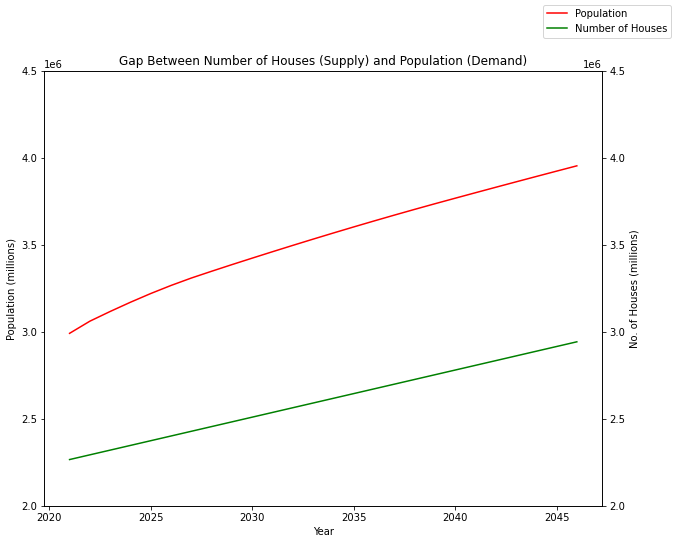

In [147]:
# Plotting Supply & Demand for 2021-2046 projection
fig, ax1 = plt.subplots()

ax1.plot(forecast_population_df['year'], forecast_population_df['population'], color='red', label="Population")
ax1.set_ylim(2_000_000, 4_500_000)
ax1.set_xlabel('Year')
ax1.set_ylabel('Population (millions)')

ax2 = ax1.twinx()
ax2.plot(forecast_housing_stock_df['year'], forecast_housing_stock_df['number_of_houses'], color='green', label="Number of Houses")
ax2.set_ylim(2_000_000, 4_500_000)
ax2.set_ylabel('No. of Houses (millions)')
fig.legend(loc="upper right")

plt.title('Gap Between Number of Houses (Supply) and Population (Demand)', fontsize=12)
plt.rcParams["figure.figsize"] = (10, 8)

#### 3-2 Lending Policy

As discussed in this article by [Toronto Times](https://totimes.ca/are-mortgage-rates-driving-up-toronto-housing-prices/), in 2020, the Bank of Canada slashed interest rates to combat COVID economic damage. The article goes on to explore how decreased mortgage rates affect housing prices in Toronto. 

Below is an excerpt of the article.

![TOT_Article](images/tot.png)

In order to investigate the effect of **Mortgage Interest Rate** on **Housing Price** in Toronto, I have made use of historic **Interest Rates** data for the last decade (available [here](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3410014501)). 

In [148]:
# Reading in interest_rates data set
interest_rates_df = pd.read_csv('data/interest_rates.csv')
interest_rates_df

,year,interest_rate
0,2010,4.82
1,2011,4.57
2,2012,4.24
3,2013,4.17
4,2014,4.08
5,2015,3.78
6,2016,3.71
7,2017,3.79
8,2018,4.37
9,2019,4.25


I want to see the trends in `Interest Rate` and `Sales Number` over the same period of time. For this, I will make use of the Number of Sales data from Toronto Regional Real Estate Board for the last decade (available [here](https://trreb.ca/files/market-stats/market-watch/historic.pdf)).

In [149]:
# Reading in sales data set
sales_df = pd.read_csv('data/sales.csv')
sales_df

,year,sales_number
0,2010,85860
1,2011,89110
2,2012,85488
3,2013,87047
4,2014,92776
5,2015,101214
6,2016,113041
7,2017,92342
8,2018,78020
9,2019,87750


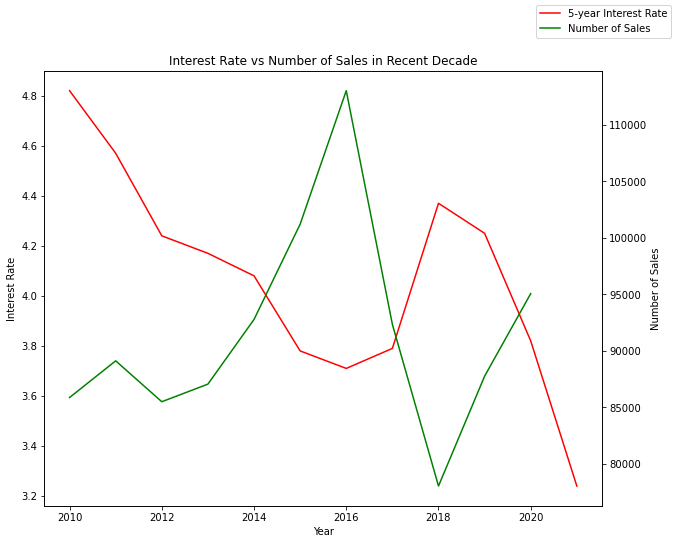

In [150]:
# Plotting 5-year Interest Rate & Number of Sales for the recent decade
fig, ax1 = plt.subplots()

ax1.plot(interest_rates_df['year'], interest_rates_df['interest_rate'], color='red', label="5-year Interest Rate")
ax1.set_xlabel('Year')
ax1.set_ylabel('Interest Rate')

ax2 = ax1.twinx()
ax2.plot(sales_df['year'], sales_df['sales_number'], color='green', label="Number of Sales")
ax2.set_ylabel('Number of Sales')
fig.legend(loc="upper right")

plt.title('Interest Rate vs Number of Sales in Recent Decade', fontsize=12)
plt.rcParams["figure.figsize"] = (10, 8)

I can see from above plot that there is a reciprocal relationship between `Interest Rate` and `Number of Sales` in Toronto which is, as mentioned before, corroborated by the literature (e.g. [here](https://www.lowestrates.ca/resource-centre/mortgage/canadian-mortgage-rates-and-housing-market-trends)).

It is therefore safe to say that lower `Interest Rate` is a driving force to an active sales market

But how big is this driving force?

[Amira Karimova](https://mpra.ub.uni-muenchen.de/103298/1/MPRA_paper_103298.pdf) proposes a model which explains the relation between the `change in housing stock` and `interest rates` for the province of Ontario.

Below is the proposed model:

![Model](images/model.png)

Here, I am only interested in $HS_{t}$ represents the `Housing Stock` and $IR_{t}$ is the `Interest Rate`. We can see the inverse (and relatively small, compared to `Population`) correlation between `Interest Rate` and `Housing Stock`, which is further discussed by the author.

It would be safe to extrapolate such a model (obviously with different coefficients) for the city of Toronto.

Below, I have plotted the `Interest Rate` and `Average Sales Price` over the last decade. Results, are in alignment with above findings.

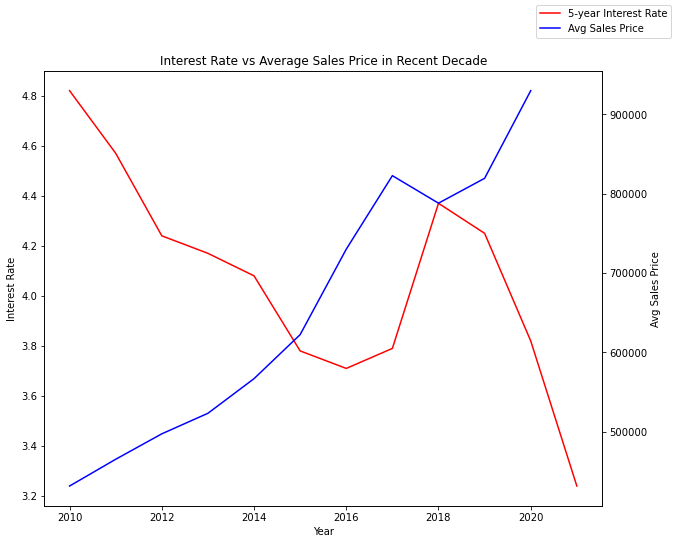

In [112]:
# Plotting 5-year Interest Rate & Average Sales Price for the recent decade
fig, ax1 = plt.subplots()

ax1.plot(interest_rates_df['year'], interest_rates_df['interest_rate'], color='red', label="5-year Interest Rate")
ax1.set_xlabel('Year')
ax1.set_ylabel('Interest Rate')

ax2 = ax1.twinx()
ax2.plot(avg_sales_price_df[(avg_sales_price_df['year'] > 2009)]['year'], avg_sales_price_df[(avg_sales_price_df['year'] > 2009)]['avg_sales_price'], color='blue', label="Avg Sales Price")
ax2.set_ylabel('Avg Sales Price')
fig.legend(loc="upper right")

plt.title('Interest Rate vs Average Sales Price in Recent Decade', fontsize=12)
plt.rcParams["figure.figsize"] = (10, 8)

As expected, the reciprocal relationship is clearly demonstrated. Where there is fall in `Interest Rate`, there is an increase in **Demand** and consequently `Sales Price` and vice versa.

Economic data often show lag in their correlations and this is also typical of above relationship.

#### 3-3 Foreign Ownership

`Foreign Ownership` is another parameter affecting Housing Market of Toronto as discussed [here](https://globalnews.ca/news/7495490/canada-foreign-buyers-tax-affordable-housing/) but this relationship is quite controversial and the data that would demonstrate this relationship is scarce.

Below, is a data set (collected in `2017`) I found from Statistics Canada Website (available [here](https://www150.statcan.gc.ca/n1/daily-quotidien/171219/dq171219b-eng.htm)) which shows that the `Foreign Ownership` for the city of Toronto is at **4.9%** only and can be concluded to have an insignificant effect of driving housing prices in the city, however, [Daniel Tencer](https://www.huffpost.com/archive/ca/entry/statistics-canada-got-it-wrong-on-foreign-homebuyers-anti-corruption-group-says_a_23325177) argues that "*because many properties in Canada (especially Toronto & Vancouver) are owned by shell corporations, it's impossible to say exactly how much Canadian real estate is in the hands of foreign owners*".

In [152]:
# Reading in foreign_owenrship data set
foreign_ownership_df = pd.read_csv('data/foreign_owenrship.csv', encoding='cp1252')
foreign_ownership_df

,region,foreign_owenership_rate
0,Toronto CMA,3.4
1,Toronto – City,4.9
2,Richmond Hill,3.6
3,Markham,3.3
4,Georgina,2.9
5,Mississauga,2.7
6,Oakville,2.6
7,Aurora,2.2
8,Mono,2.1
9,King,1.9


### 4- Conclusions and Recommendations

#### 4-1 Conclusions

In this analysis, I made an attempt to answer the below Driving Question:

"*Why are houses so expensive in Toronto?*"

To do so, I started to take a look at the current Housing Market in Toronto using `Unaffordability Ratio` as a proxy.

Next, I investigated the effect of 3 key parameters namely:
- Supply/Demand
- Lending Policy
- Foreign Ownership

and conluded:

- 1- The balance between `Supply` and `Demand` is the main driver of `Housing Prices` in Toronto and other parameters basically affect the market through this balance. Results show that there is a huge gap between Supply (mainly `Number of Existing Houses`) and Demand (mainly `Population`). This is not only a historical trend but also a trend to be expected in at least the next **2-3** decades.

- 2- The recent decreasing rate in `Lending Rates` (amplified by the current economic situation around pandemic) has facilitated the purchasing process and has consequently increased the Demand. The data show that this was concurred with an increase in `Housing Prices`. However, this correlation is week compared to `Population`.

- 3- Foreign Ownership does affect the Housing Prices in Toronto as witnessed by the literature, however there are not enough data on this parameter to make data-driven conclusions.

#### 4-2 Recommendation

As requested in the assignment, I have come up with the following policy proposals that I believe are most likely to reduce housing prices by the largest magnitude:

- 1- Legislations should be passed to help fill the gap between Supply and Demand in the housing market of city of Toronto. This can be in form of policies that would contribute to facilitating the construction process. Examples are:
> - Incentives for constructors/contractors that would complete construction projects on or ahead of schedule
> - Strict rules assuring construction is on schedule and if behind schedule penalty measures are in place
> - Decreasing constructions costs and related tax rates

- 2- Since many properties in Toronto are owned by **[shell corporations](https://en.wikipedia.org/wiki/Shell_corporation)** policies should be in place to:
> - To make the beneficial owners of shell companies public
>- To tax foreign homeowners who live outside of Canada as part of a plan to lower housing prices

### This is the end of the report.

### Thanks again Validere team! 👍